In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

class VariantCalling:
    def __init__(self, mutation_labels, mutation_types_names, file_name) -> None:
        self.mutation_labels = mutation_labels
        self.mutation_type_names = mutation_types_names
        self.NUCLEOTIDES = "ACGT"
        self.transdict = {"A":0, "C": 1, "G":2, "T":3}

        self.clones = []
        with open(file_name, "r") as f:
            for clone in f:
                alignment = []
                for char in clone.strip():
                    alignment.append(char)
                self.clones.append(alignment)
        self.nb_clones = len(self.clones)

class VariantCallingData(VariantCalling):
    """Class for simulated data generation"""
    def __init__(self, 
                 mutation_labels={"no_SNP": 0, "heterozygous_SNP": 1, "homozygous_SNP": 2},
                 mutation_types_names={0: "No mutation", 1: "Heterozygous SNP", 2: "Homozygous SNP"},
                 file_name="../input/clone-file/clones.txt"
                 ) -> None:
        super().__init__(mutation_labels=mutation_labels, mutation_types_names=mutation_types_names,
                         file_name=file_name)
        self.alignments = None
        self.mutation_types = None
                
    def simulate_alignments(self, reference_length=200, 
                        num_alignments = 2000, 
                        coverage = 100, 
                        mutations = None,
                        p_sequencing_error=0.0,
                        p_alignment_error=0.00) -> tuple:
        """Modified provided function to generate simulated data for the project.
        
        Inputs
        ------
        reference_length: Width of the image.
        num_alignments: Size of data samples (1 sample is 1 image).
        coverage: Height of the image.
        mutations: Contains the keys of the mutation types. 
                    If None, use self.mutation_labels.
        p_sequencing_error: Probability of sequencing error.
        p_alignment_error: Probability of alignment error.

        Outputs
        -------
        tuple: (alignments, mutation_types)
        alignments: 3D np.array containing the data in the shape 
                    (num_alignments, coverage + 1, reference_length).
        mutation_types: python list of integers indicating the mutation 
                        type of each sample of data in alignments. 
                        size of num_alignments.
        """
        if mutations is None:
            mutations = self.mutation_labels.keys()

        alignments = []
        mutation_types = []
        
        for i in range(num_alignments):
            snp_index = reference_length // 2 
            if (i % 400 == 0):
                print("Computing alignment ", i)
            reference = [random.choice(self.NUCLEOTIDES) for _ in range(reference_length)]
            reference_base_at_snp = reference[snp_index]
            snp_base = random.choice([i for i in self.NUCLEOTIDES if i != reference_base_at_snp])
            mutation_type=random.choice([self.mutation_labels[m] for m in mutations]) 
            mutation_types.append(mutation_type)
            
            alignment = [reference] #first read is always the reference
            for _ in range(coverage):
                mut_index = snp_index
                new_read = [reference[i] if random.random() > p_sequencing_error 
                            else random.choice(self.NUCLEOTIDES) for i in range(reference_length)]
                if random.random() < p_alignment_error:
                    mut_index = snp_index + random.randint(-1,2)
                if mutation_type == 1 and random.random() > 0.5: # heterozygous SNP
                    new_read[mut_index] = snp_base            
                if mutation_type == 2: #homozygous SNP
                    new_read[mut_index] = snp_base
                if random.random() < p_sequencing_error: #Add errors to SNP region also
                    new_read[mut_index] =  random.choice(self.NUCLEOTIDES)
                alignment.append(new_read)
            alignments.append(alignment)

        self.alignments = alignments
        self.mutation_types = mutation_types
        return np.array(alignments), mutation_types
    

    def char_to_int(self, alignments=None) -> np.ndarray:
        """Maps the char ACGT to the corresponding integers"""
        if alignments is None:
            alignments = self.alignments
        return np.vectorize(self.transdict.get)(alignments)
    
    def plot_data(self, alignments_ints=None, mutation_types=None, mutation_index=0) -> None:
        """Use to plot an alignment at a certain mutation type
        
        Note
        ----
        This Function should be refactored, or a new function should be created
        """
        if alignments_ints is None or mutation_types is None:
            alignments_ints = self.char_to_int()
            mutation_types = self.mutation_types
        
        plt.rcParams['figure.dpi'] = 200
        alignment_idx = mutation_types.index(mutation_index)
        plt.title(f"Mutation type: {self.mutation_type_names[mutation_types[alignment_idx]]}")
        plt.imshow(alignments_ints[alignment_idx],cmap='jet')

    def simulate_clones(self, num_alignments = 2000, 
                        coverage = 100, 
                        p_sequencing_error=0.0,
                        p_alignment_error=0.00,
                        verbose=1) -> (np.ndarray, list) :
        """Wrapper to generate n alignments as specified in num_alignments.
        NOTE: Consider to merge this into simulate_alignments in the future.
        
        Parameters
        ----------
        num_alignments : <int>
            Number of alignments to be generated
        coverage : <int>
            Number of read for an alignment
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1 
        verbose : <int>
            0 - No progress will be printed
            1 - Progress will be printed for every 400 num_alignments
        Returns
        -------
        np.ndarray :
            Numpy array of alignments generated.
        list :
            List of lists of probability for each of the alignment
        """
        alignments = []
        prob_lists = []
        for i in range(num_alignments):
            if (i % 400 == 0) and (verbose==1):
                print("Progress:  {progress_percentage}%% completed. \tComputing alignment {current_iter} of {total_iter}".format(progress_percentage=round(i*100/num_alignments,2), current_iter = i, total_iter=num_alignments))
            alignment, prob_list = self.ratio_gen(coverage, p_sequencing_error, p_alignment_error)
            alignments.append(alignment)
            prob_lists.append(prob_list)
        self.alignments = alignments
        return np.array(alignments), prob_lists

    def ratio_gen(self, coverage, p_sequencing_error, p_alignment_error) -> (list,list):
        """Wrapper to generate a single alignment based on a randomly generated ratio
        Returns np.ndarray of the alignment and the probability of the distribution

        NOTE: Naming of variables shall be improved in the future for easy readability
        
        Parameters
        ----------
        coverage : <int>
            Number of read for an alignment
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1 
        Returns
        -------
        list
            List of reads for an alignment
        list
            Probability distribution for the alignment read for each of the clone class
        """
        prob_dist = self._gen_prob_list(self.nb_clones, mode=2)
        nb_coverage_list = []
        for prob in prob_dist:
            nb_coverage_list.append(math.floor(prob * coverage))
        for _ in range(coverage - sum(nb_coverage_list)):
            # We randomly increase an element by 1 until we reach the number of coverages specified (n - 1)
            # as the first row is always the reference
            nb_coverage_list[random.randint(0,self.nb_clones - 1)] += 1
        
        coverage_list = []
        for clone_idx, nb_clone_coverage in enumerate(nb_coverage_list):
            for _ in range(0,nb_clone_coverage):
                coverage_list.append(
                    self._add_errors(self, self.clones[clone_idx],p_sequencing_error,p_alignment_error))
        
        # This will be the final probability list
        prob_list = [nb_coverage_list[i]/coverage for i in range(0, len(nb_coverage_list))]

        # Here we shuffle the list and concatenate into the final alignment
        choice_indices = np.random.choice(len(coverage_list), coverage, replace=False)
        alignment = [self.clones[0]] # First row is always reference (assumed to be index at 0)
        alignment += [coverage_list[i] for i in choice_indices] # Concatenate the randomized read to the reference row

        return alignment, prob_dist

    @staticmethod
    def _add_errors(self, clone, p_sequencing_error, p_alignment_error) -> list:
        """
        Adds sequencing error and alignment error to a single read, returns clone with error
        Parameters
        ----------
        clone : <List> 
            List of the base-pair encoded in <int>
        p_sequencing_error : <double>
            Probability of sequencing error, takes value >= 0, <= 1
        p_alignment_error : <double>
            Probability of alignment error, takes value >= 0, <= 1
        
        Returns
        -------
        list
            List of bp based on input clone with sequencing and alignment errors added
        """
        # Let's make alignment error applicable to all for now
        new_clone = [clone[i] if random.random() > p_alignment_error 
                     else clone[min(max(0, i + random.randint(-1,2)),len(clone)-1)] for i in range(len(clone))]
        return [new_clone[i] if random.random()> p_sequencing_error
                else random.choice(self.NUCLEOTIDES) for i in range(len(new_clone))]

    def _gen_prob_list(self, nb_class, mode=1) -> list:
        """Generate a list of nb_class elements of probability that sum to 1
        Leaving the nb_class to maintain modularity in case we need to generate 
        probability for other purposes.
        
        Parameters
        ----------
        nb_classes : <int>
            Number of classes of probability to be generated
        
        mode : <int>
            Mode of the randomizer, it seems like the Dirichlet's Distribution outputs overly balanced distribution
            1 : Dirichlet's Distribution - Seems to be quite balanced, often returns within mean of p=0.33
            2 : random.random() - Generates nb_class random numbers that are normalized against the sum
        Returns
        -------
        list
            List of <nb_class> element representing the probability for each of the class.
        """
        match mode:
            case 1: 
                return (np.random.dirichlet(np.ones(nb_class)*1000.,size=1)).flatten().tolist()
            case 2:
                prob_list = [random.random() for _ in range(0,nb_class)]
                return [prob_list[i] / sum(prob_list) for i in range(0, nb_class)]

    def _array_dup(self,arr,coverage) -> np.ndarray: 
        """Produces an array of the reference genome repeated - this is used as a second channel in CNN, Will's Code
        
        Parameters
        ----------
        arr : TYPE
            Input alignment data
        
        coverage : TYPE
            Size of the amplicon
        coverage: 
        
        Returns
        -------
        np.ndarray
            2-dimensional array with second channel as the reference row
        """

        # NOTE: We should be able to get size of coverage from len(arr[0]) but faced np.tile issue (the output shape is different)
        # when passing len(ref_gen) instead of coverage to np.tile, non-blocking but good to be solved in the future.
        ref_gen = arr[0]
        ref_gen_matrix = np.tile(ref_gen,(coverage,1))
        aln_ref_dim = np.array((arr, ref_gen_matrix))
        return aln_ref_dim


Progress:  0.0%% completed. 	Computing alignment 0 of 10
[0.5182235274715734, 0.2886516090785696, 0.19312486344985694]


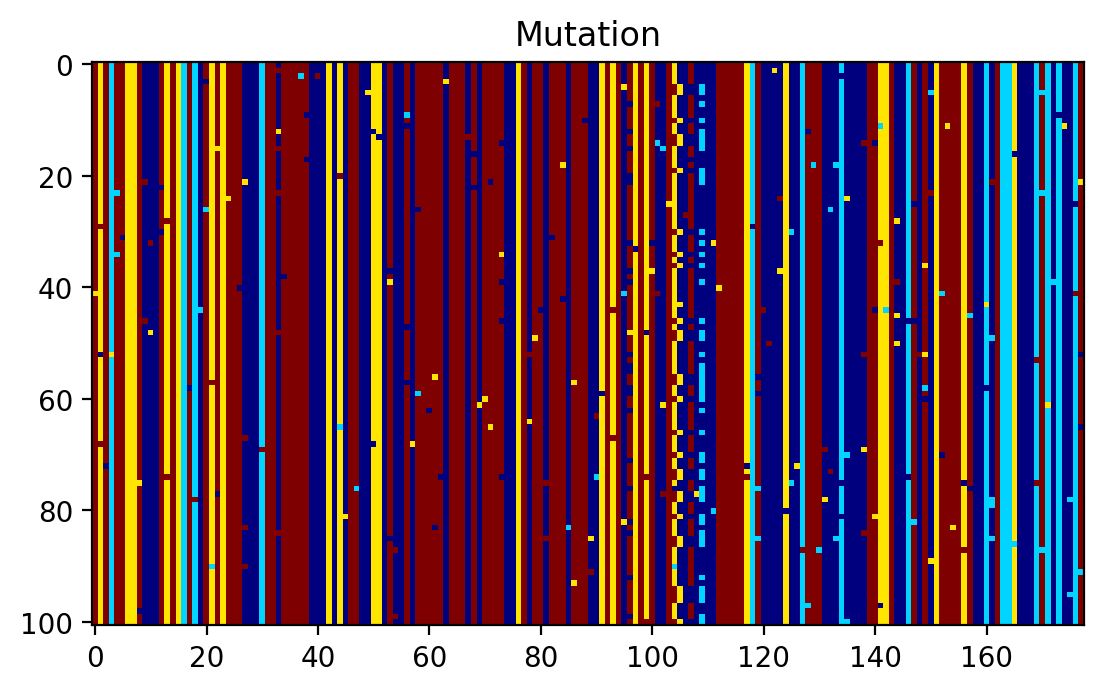

In [3]:
# sfsd

import torch
import torch.nn as nn
import torch.nn.functional as F
# import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# file_name = pd.read_txt('../input/clone-file/clones.txt')


"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10,100,0.01,0.01)
alignments_int = dg.char_to_int(alignments)
alignment_int = dg.char_to_int(alignments[0])
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignment_int,cmap='jet')
print(prob_lists[0])



Progress:  0.0%% completed. 	Computing alignment 0 of 10
101
101
10
(2, 101, 178)
[[['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]

 [['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ...
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']
  ['T' 'G' 'T' ... 'A' 'C' 'T']]]
(8, 2, 101, 178)
(8, 3)
Shape of x before flattening: torch.Size([8, 256, 6, 11])
Shape of x before flattening: torch.Size([2, 256, 6, 11])
epoch= 1, train_loss=0.198, valid_loss=18.608, r2=-3168.564, mse=18.608
Shape of x before flattening: torch.Size([8, 256, 6, 11])
Shape of x before flattening: torch.Size([2, 256, 6, 11])
epoch= 2, train_loss=2676.561, valid_loss=0.020, r2=-2.150, mse=0.020
Shape of x before flattening: torch.Size([8, 256, 6, 11])
Shape of x before flattening: torch.Size([2, 256, 6, 11])
epoc

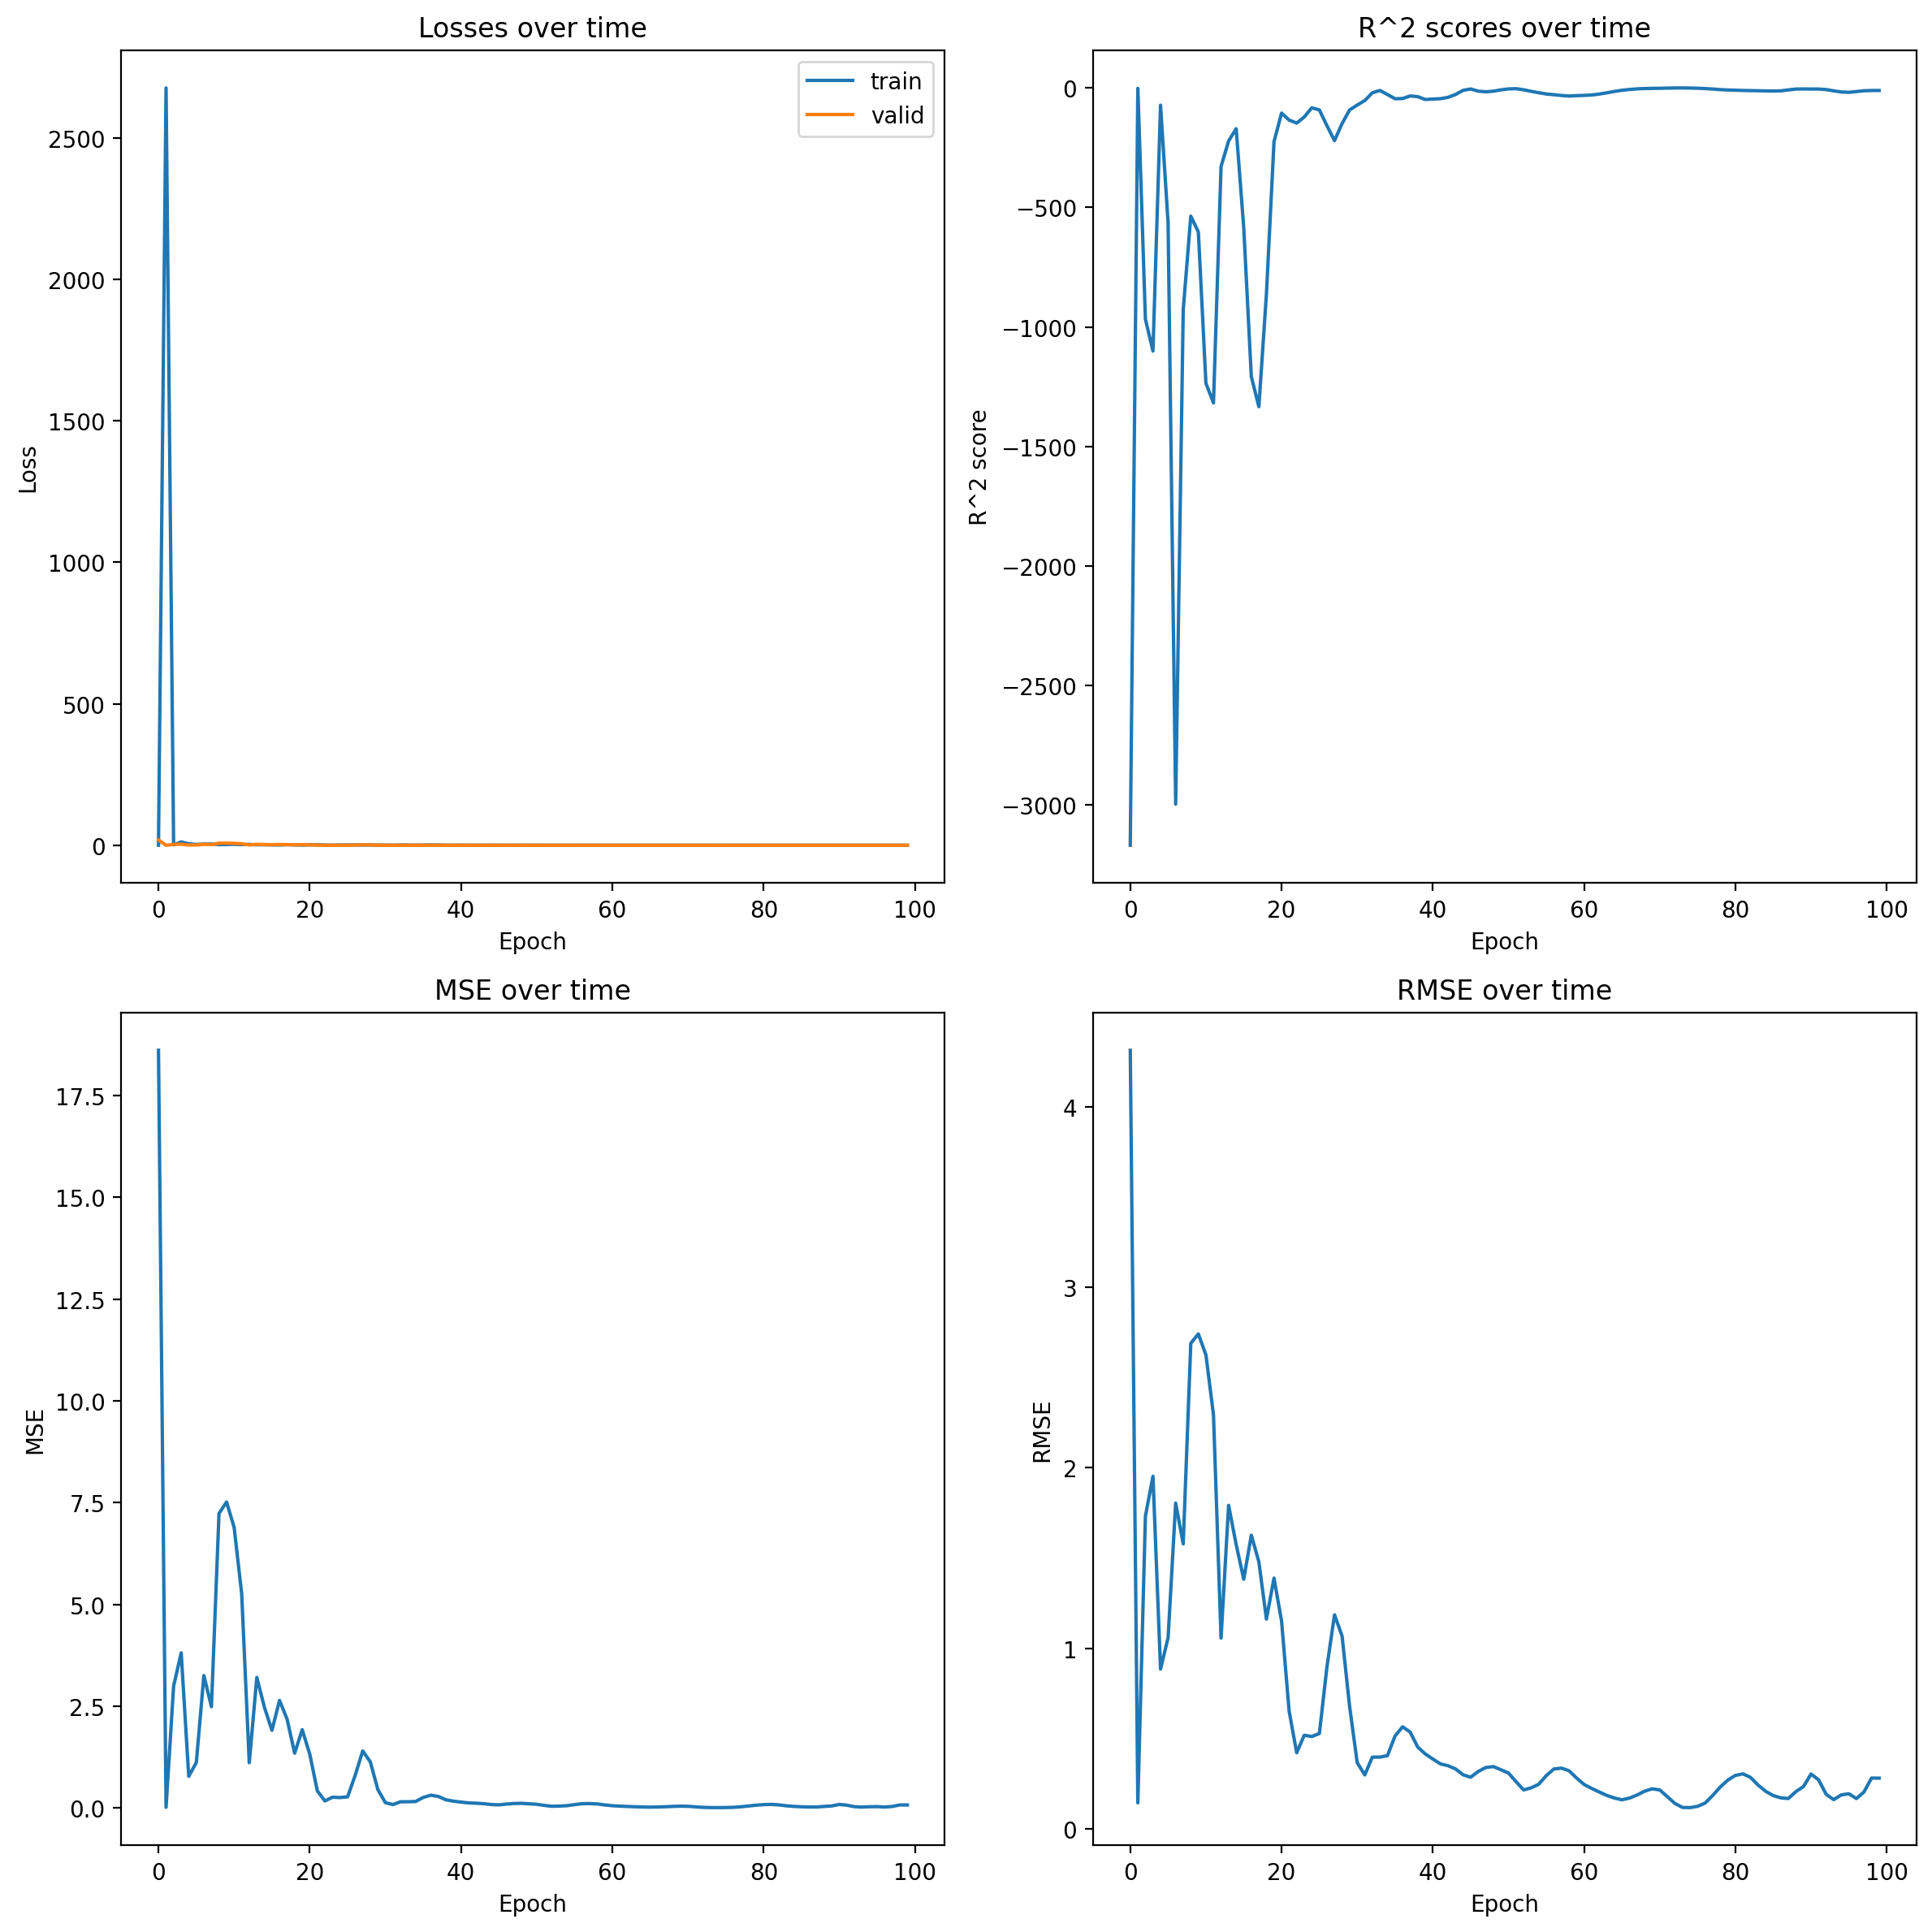

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = VariantCallingData()
alignments, prob_lists = dg.simulate_clones(10,100,0.01,0.01)

orgn = alignments[0]
print(len(orgn))

valid_rmse_scores = []


print(len(alignments[0]))
alignments = [dg._array_dup(i,101) for i in alignments]
print(len(alignments))

print(alignments[8].shape)
print(alignments[8])
alignments_int = dg.char_to_int(alignments)

rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments_int.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments_int.shape[0]*0.8)
train_alignments, valid_alignments = alignments_int[idxs[:split_idx]], alignments_int[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1) # input channels, output channels, kernel size
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16896, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3) # Changed from (60, 3) to (128, 3)
        
        self.dropout = nn.Dropout(0.25)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)
        

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))
        print(f"Shape of x before flattening: {x.shape}")
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
     
        return x

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def train_regression(model, train_alignments, train_prob_lists, valid_alignments, valid_prob_lists, epochs=10, lr=0.001):
    crit = torch.nn.MSELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_alignments).float(), torch.from_numpy(train_prob_lists).float()
    )
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(valid_alignments).float(), torch.from_numpy(valid_prob_lists).float()
    )

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=16)

    train_losses, valid_losses, valid_r2_scores, valid_mses, valid_rmse_scores, valid_mae_scores = [], [], [], [], [], []

    for epoch in range(1, epochs + 1):
        # train for 1 epoch
        model = model.train()
        epoch_loss, total = 0.0, 0
        for i, (batch_alignment, batch_prob_list) in enumerate(train_loader):
            opt.zero_grad()
            out = model(batch_alignment)
            loss = crit(out, batch_prob_list)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            total += 1
        epoch_loss /= total

        # compute validation loss and metrics
        model = model.eval()
        valid_loss, n, total = 0.0, 0, 0
        valid_preds, valid_targets = [], []
        for i, (batch_alignment, batch_prob_list) in enumerate(valid_loader):
            with torch.no_grad():
                out = model(batch_alignment)
                loss = crit(out, batch_prob_list)
                valid_preds.extend(out.detach().numpy())
                valid_targets.extend(batch_prob_list.numpy())
            valid_loss += loss.item()
            total += 1
        valid_loss /= total
        r2 = r2_score(valid_targets, valid_preds)
        mse = mean_squared_error(valid_targets, valid_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(valid_targets, valid_preds)

        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        valid_r2_scores.append(r2)
        valid_mses.append(mse)
        valid_rmse_scores.append(rmse)
        valid_mae_scores.append(mae)

        print(f"epoch={epoch:2d}, train_loss={epoch_loss:.3f}, valid_loss={valid_loss:.3f}, r2={r2:.3f}, mse={mse:.3f}")

    return train_losses, valid_losses, valid_r2_scores, valid_mses, valid_rmse_scores, valid_mae_scores

# Rest of the code remains the same...

model = CNN()
n_epochs = 100
lr = 0.003

model.fc3 = nn.Linear(128, 3)

train_losses, valid_losses, valid_r2_scores, valid_mses, valid_rmse_scores, valid_mae_scores = train_regression(
    model, train_alignments, train_prob_lists, valid_alignments, valid_prob_lists, epochs=n_epochs, lr=lr
)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot training and validation losses over time
axs[0, 0].plot(train_losses, label='train')
axs[0, 0].plot(valid_losses, label='valid')
axs[0, 0].set_title('Losses over time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot validation R^2 scores over time
axs[0, 1].plot(valid_r2_scores)
axs[0, 1].set_title('R^2 scores over time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('R^2 score')

# Plot validation MSE over time
axs[1, 0].plot(valid_mses)
axs[1, 0].set_title('MSE over time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('MSE')

# Plot validation RMSE over time
axs[1, 1].plot(valid_rmse_scores)
axs[1, 1].set_title('RMSE over time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()
